<h1><center> EXPL Project4 ARIMA </center></h1>
<h1><center>Project4 : Predicting Stock Price</center></h1>

- [Yahoo Stock Price Data Set](https://finance.yahoo.com/)
- file name: ARIMA_project4_005930.KS.csv, it's already in your data folder

# module importing and version checking

In [179]:
import pandas
import sklearn
import statsmodels
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.5.2
1.1.3
0.13.2


## 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os

plt.rcParams['font.family'] = 'AppleGothic'

file_path = os.getenv('HOME') + '/Documents/projects/Aiffel/lms/data/ARIMA_project4_005930.KS.csv'
# Time Series 생성
df_ts = pd.read_csv(file_path, index_col = 'Date', parse_dates= True)
print(df_ts.shape, df_ts.columns, type(df_ts))
ts = df_ts['Close']
ts.head()

(250, 6) Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') <class 'pandas.core.frame.DataFrame'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 각종 전처리 수행
- 결측치 처리
- 로그 변환

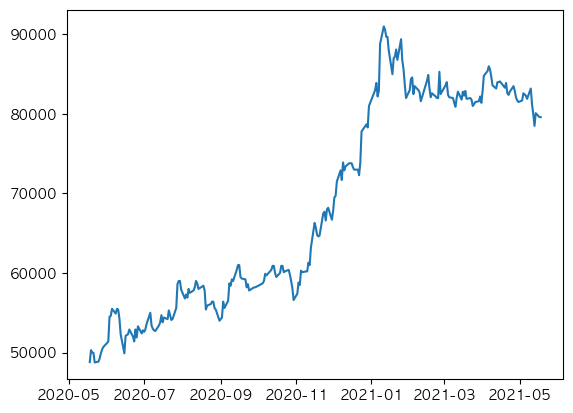

In [181]:
plt.plot(ts)
plt.show()

In [182]:
# 결측치 처리
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

- 결측치가 없어 빈 Series파일이 출력됨

In [183]:
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

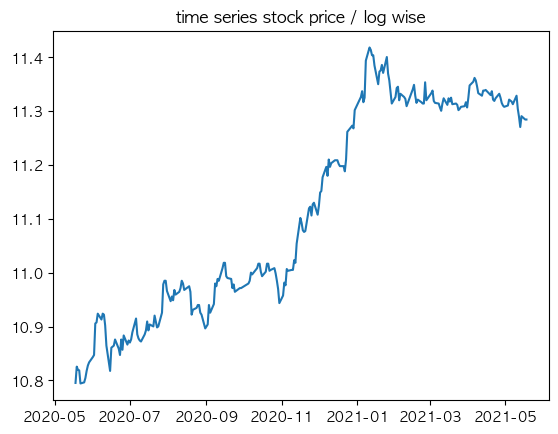

In [184]:
plt.plot(ts_log)
plt.title("time series stock price / log wise")
plt.show()

## 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [185]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

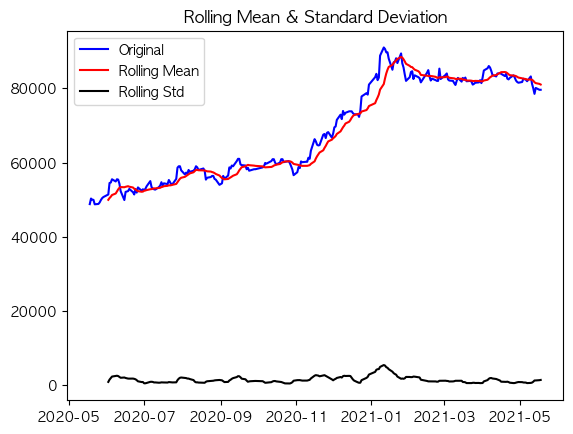

In [205]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

In [187]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [188]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- p-value 가 .6638로 귀무가설을 기각할 수 없다

In [189]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- log 함수로 변환하여도 p-value가 낮아지긴 하였으나 여전히 .5901로 귀무가설을 기각할 수 없다.

In [190]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

In [191]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


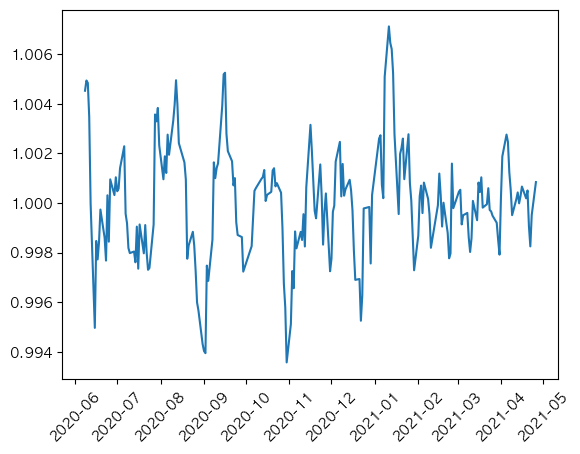

In [192]:
plt.plot(residual)
plt.xticks(rotation = 45)
plt.show()

- 시계열 데이터를 log로 변환 후, trend 및 계절성을 제거한 후 augmented_dickey_fuller_test를 수행한 결과 p-value가 0.001이하 즉, $6.2349 * 10^{-8}$로 매우 낮게 나와 귀무가설을 기각하고 시계열 데이터로 볼 수 있다.

## 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

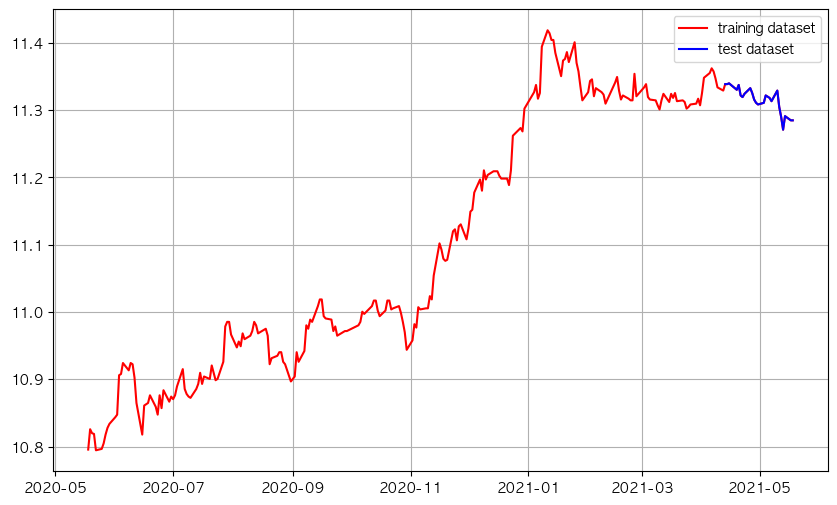

In [207]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

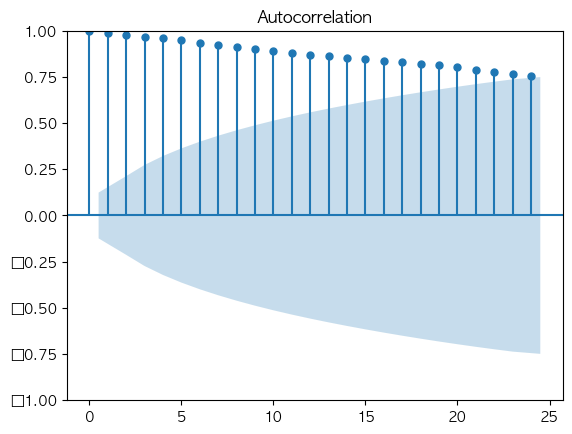

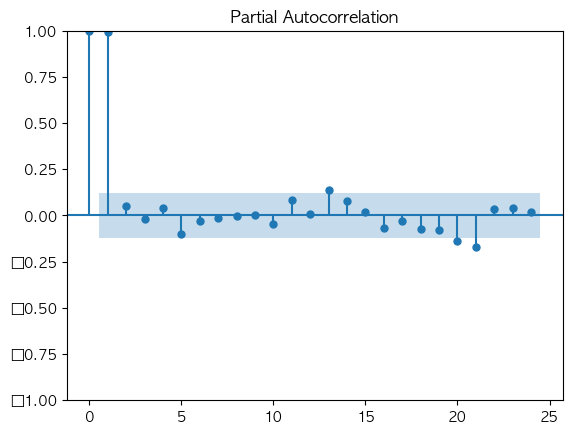

In [208]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- PACF로 확인컨데 p = 2 이 적당해 보이며 q =24

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


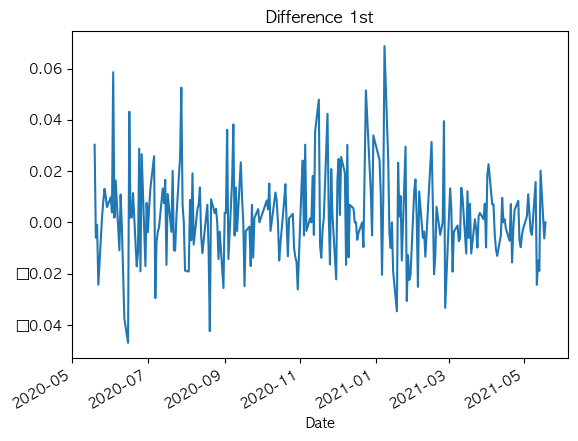

In [195]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분에서 p-value가 매우 낮은 값이 나와 d=1로 두어도 충분할 것으로 사료됨
- p = 1, q = 0 ,d =1

## ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [248]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 24)) # 모수는 이전 그래프를 참고 order = (p,d,q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(2, 1, 24)   Log Likelihood                 593.343
Date:                Wed, 21 Dec 2022   AIC                          -1132.686
Time:                        23:18:51   BIC                          -1040.572
Sample:                             0   HQIC                         -1095.504
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2476      0.368      0.673      0.501      -0.474       0.969
ar.L2         -0.3571      0.318     -1.125      0.261      -0.979       0.265
ma.L1         -0.1992      0.374     -0.533      0.5

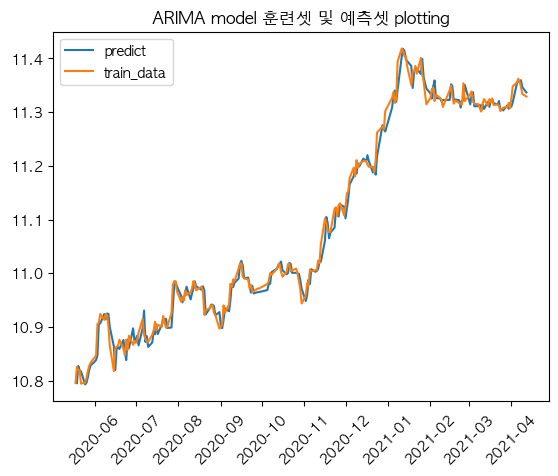

In [249]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.xticks(rotation = 45)
plt.title("ARIMA model 훈련셋 및 예측셋 plotting")
plt.legend()

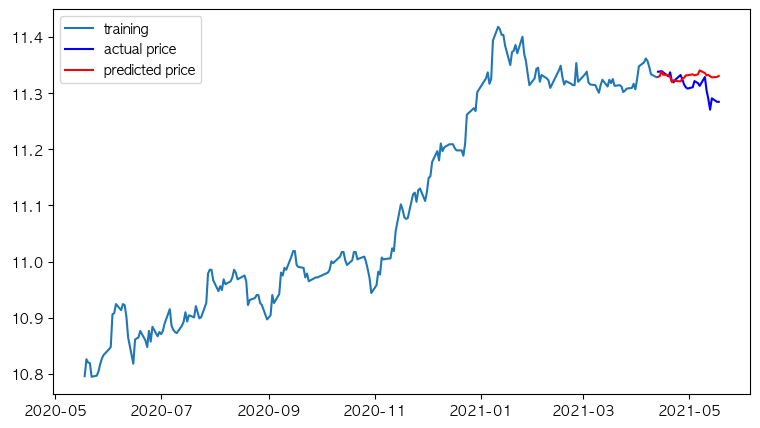

In [252]:
model = ARIMA(train_data, order=(2, 1, 25))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index = test_data.index).copy()# 예측결과
fc_series[:] = fc

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [253]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc_series))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_series))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_series)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_series) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3971532.608614605
MAE:  1481.5872200945246
RMSE:  1992.8704445132917
MAPE: 1.83%


## 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

In [227]:
file_path = os.getenv('HOME') + '/Documents/projects/Aiffel/lms/data/ARIMA_project4_035720.KS.csv'
# Time Series 생성
df_ts = pd.read_csv(file_path, index_col = 'Date', parse_dates= True)
print(df_ts.shape, df_ts.columns, type(df_ts))
ts = df_ts['Close']
ts.head()

(1229, 6) Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') <class 'pandas.core.frame.DataFrame'>


Date
2017-12-21    25989.724609
2017-12-22    26090.460938
2017-12-26    25385.312500
2017-12-27    28105.167969
2017-12-28    27601.490234
Name: Close, dtype: float64

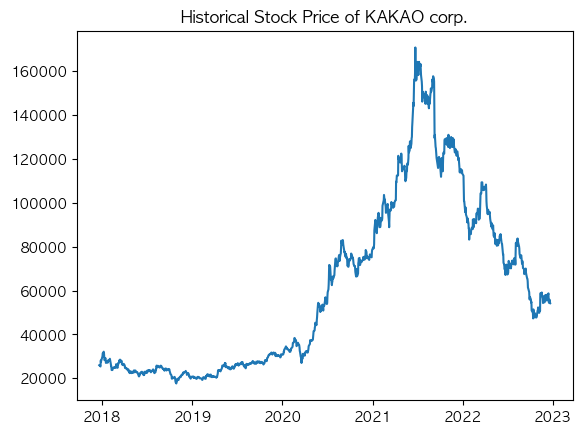

In [254]:
# 데이터 plotting
plt.plot(ts)
plt.title("Historical Stock Price of KAKAO corp.")
plt.show()

In [255]:
# 결측치 처리
ts[ts.isna()]  # 결측치 없음

Series([], Name: Close, dtype: float64)

In [256]:
#log 변환
ts_log = np.log(ts)

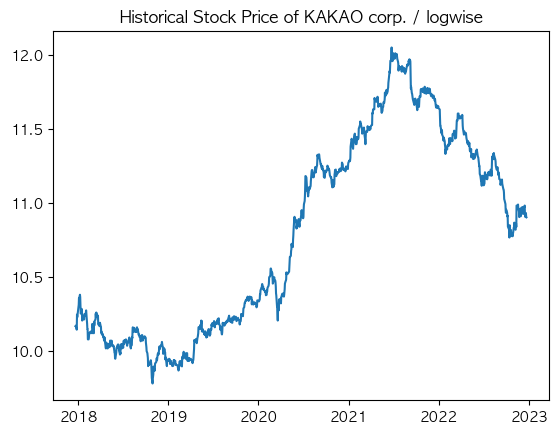

In [258]:
# log변환 plotting 
plt.plot(ts_log)
plt.title("Historical Stock Price of KAKAO corp. / logwise")
plt.show()

In [259]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

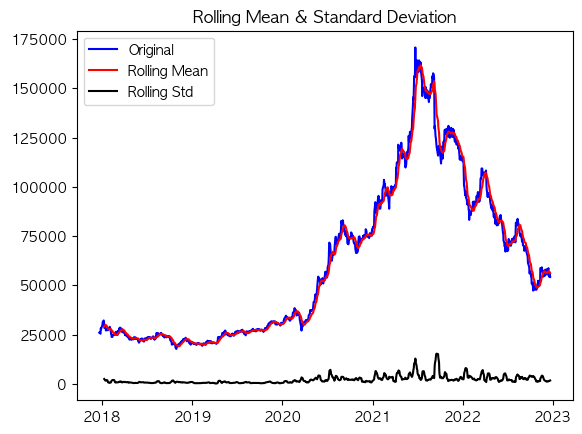

In [260]:
# 정성적 ts plotting
plot_rolling_statistics(ts, window=12)

In [261]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [262]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.937170
p-value                           0.775486
#Lags Used                        3.000000
Number of Observations Used    1225.000000
Critical Value (1%)              -3.435699
Critical Value (5%)              -2.863902
Critical Value (10%)             -2.568028
dtype: float64


In [263]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 12) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

In [264]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.036251e+01
p-value                        2.376197e-18
#Lags Used                     2.300000e+01
Number of Observations Used    1.193000e+03
Critical Value (1%)           -3.435843e+00
Critical Value (5%)           -2.863966e+00
Critical Value (10%)          -2.568061e+00
dtype: float64


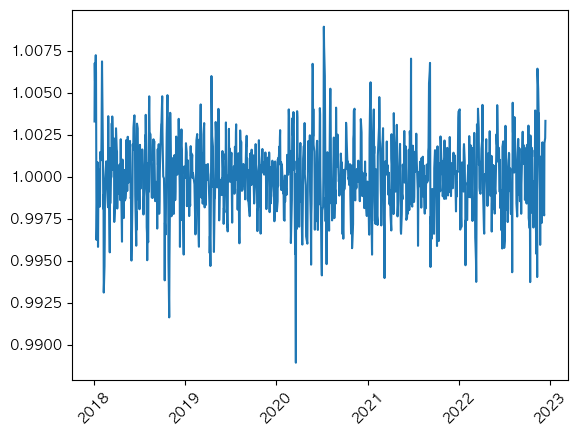

In [265]:
plt.plot(residual)
plt.xticks(rotation = 45)
plt.show()

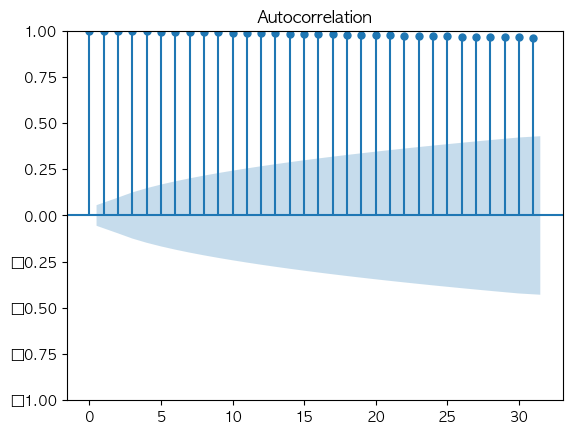

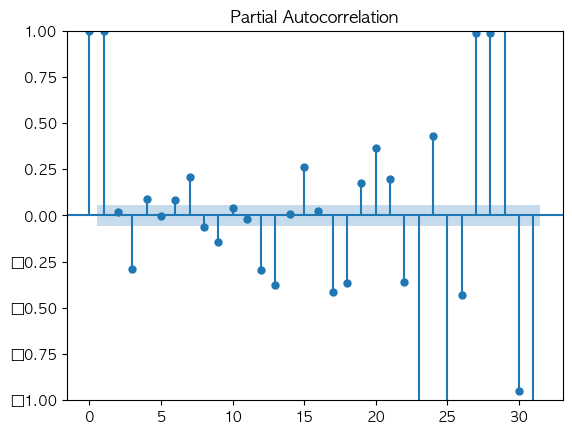

In [266]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.817125e+01
p-value                        2.446677e-30
#Lags Used                     2.000000e+00
Number of Observations Used    1.225000e+03
Critical Value (1%)           -3.435699e+00
Critical Value (5%)           -2.863902e+00
Critical Value (10%)          -2.568028e+00
dtype: float64


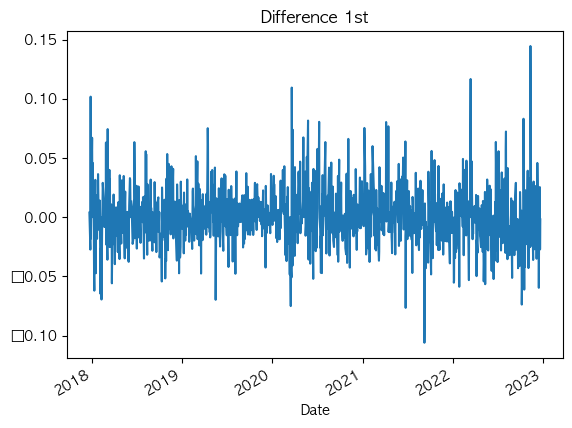

In [246]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- d = 1
- p, q = 1(불안정하여 변화를 줘가며 살펴볼 필요 있음), 30++(50이상의 큰 수로 예상됨)

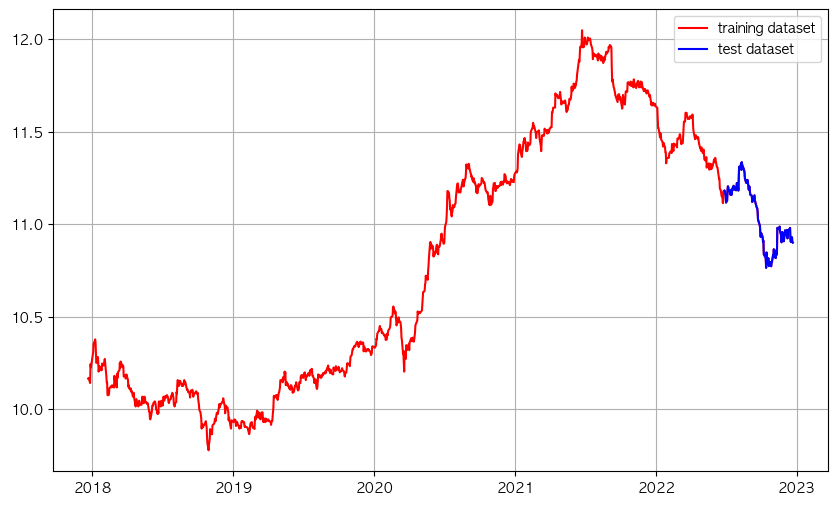

In [271]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [280]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(10, 1, 50)) # 모수는 이전 그래프를 참고 order = (p,d,q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1106
Model:               ARIMA(10, 1, 50)   Log Likelihood                2615.171
Date:                Wed, 21 Dec 2022   AIC                          -5108.341
Time:                        23:34:41   BIC                          -4802.878
Sample:                             0   HQIC                         -4992.808
                               - 1106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1946      3.612      0.054      0.957      -6.885       7.274
ar.L2          0.1068      3.394      0.031      0.975      -6.544       6.758
ar.L3          0.1166      1.832      0.064      0.9

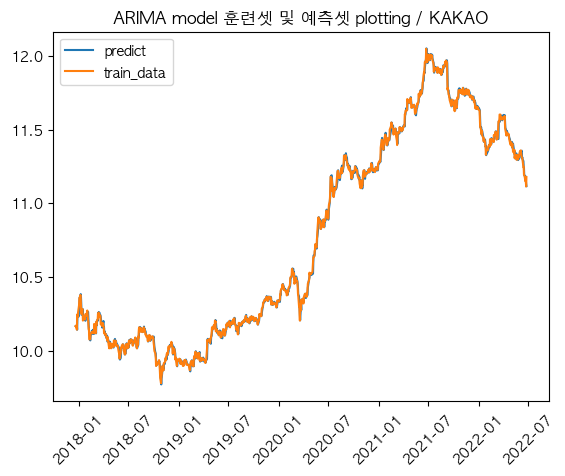

In [275]:
fitted_m2 = fitted_m.predict()
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
plt.plot(fitted_m2, label='predict')
plt.plot(train_data, label='train_data')
plt.xticks(rotation = 45)
plt.title("ARIMA model 훈련셋 및 예측셋 plotting / KAKAO")
plt.legend()

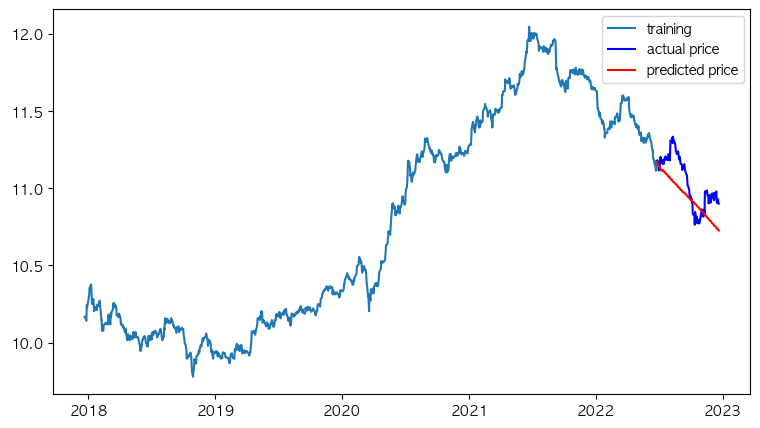

In [299]:
model = ARIMA(train_data, order=(5, 2, 20))  # p,d,q = 15,1,50
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index = test_data.index).copy()# 예측결과
fc_series[:] = fc

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [288]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc_series))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_series))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_series)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_series) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  57427723.10088437
MAE:  6335.342392187841
RMSE:  7578.108147874664
MAPE: 9.85%
